##Part 2: Fine-tuning Stable Diffusion

To train stable diffusion on our images, we can use a technique called fine-tuning, which involves taking a pre-trained stable diffusion model and training it further on a new dataset. In this way, we can leverage the knowledge already learned by the pre-trained model and adapt it to the new dataset, allowing us to achieve better performance with less training time. In this context, we will be fine-tuning a stable diffusion model on our own images, which will enable us to generate new images that are similar in style and content to our original dataset. Once we have fine-tuned the model, we will be able to use it for inference, generating new images on demand.

In [1]:
!cd /content/
!git clone https://github.com/huggingface/diffusers.git
!pip install ./diffusers
!pip install -U -r /content/diffusers/examples/text_to_image/requirements.txt

Cloning into 'diffusers'...
remote: Enumerating objects: 27034, done.
remote: Counting objects: 100% (606/606), done.
remote: Compressing objects: 100% (290/290), done.
remote: Total 27034 (delta 371), reused 475 (delta 291), pack-reused 26428
Receiving objects: 100% (27034/27034), 18.46 MiB | 35.59 MiB/s, done.
Resolving deltas: 100% (19684/19684), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.18.0.dev0-py3-none-any.whl size=1081907 sha256=3bd6bab6e9ed9a71d373098faaef32e86ccc8001d38939cc4e3290c61cb5327b
  Stored in directory: /tmp/pip-ephem-wheel-cache-rz2ca4ml/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully b

Let's configure HuggingFace Accelerate, a platform for allowing us to automatically configure our system to be able to run our training script. You can learn more about Accelerate [here](https://huggingface.co/docs/accelerate/index).

In [2]:
!nvidia-smi

Sat Jun 10 19:26:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!accelerate config default --mixed_precision fp16

2023-06-10 19:27:16.685383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


Time to configure our environment variables. For this, we want to tell the script our model name, dataset name, and where we would like it to output the model. We will be automatically pushing the model directly to HuggingFace Hub which will require us to login to our HuggingFace account using the token provided through your HuggingFace account settings.

In [4]:
import os

os.environ['MODEL_NAME'] = f'CompVis/stable-diffusion-v1-2'
os.environ['DATASET_NAME'] = f'Ali-fb/martin_valen_dataset'
os.environ['OUTPUT_DIR'] = f'sd_martin_valen-model-v1-2_400_demo'

In [5]:
from huggingface_hub import notebook_login
notebook_login()

Run our training script using HuggingFace accelerate. We'll be inputing our dataset and model with 400 steps (selected) and 134 epochs (default). The model will then be automatically pushed to the hub.

In [6]:
!accelerate launch diffusers/examples/text_to_image/train_text_to_image.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --mixed_precision="fp16" \
  --max_train_steps=400 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --push_to_hub \
  --checkpointing_steps=100000 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --output_dir=$OUTPUT_DIR 

2023-06-10 19:30:05.710520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-10 19:30:10.130277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
06/10/2023 19:30:12 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'variance_type', 'thresholding', 'clip_sample', 'prediction_type', 'dynamic_thresholding_ratio', 'sample_max_value', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'norm_num_groups', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'num_class_embeds', 'cross_attention_norm', 'encoder_hid_dim', 'resnet_out_scale_factor', 'time_cond_proj_dim', 'conv_in_kernel', 'use_linear_projection', 'timestep_post_act', 'time_embedding_dim', 'addition_embed_type', 'addition_embed_type_num_heads', 'mid_block_

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

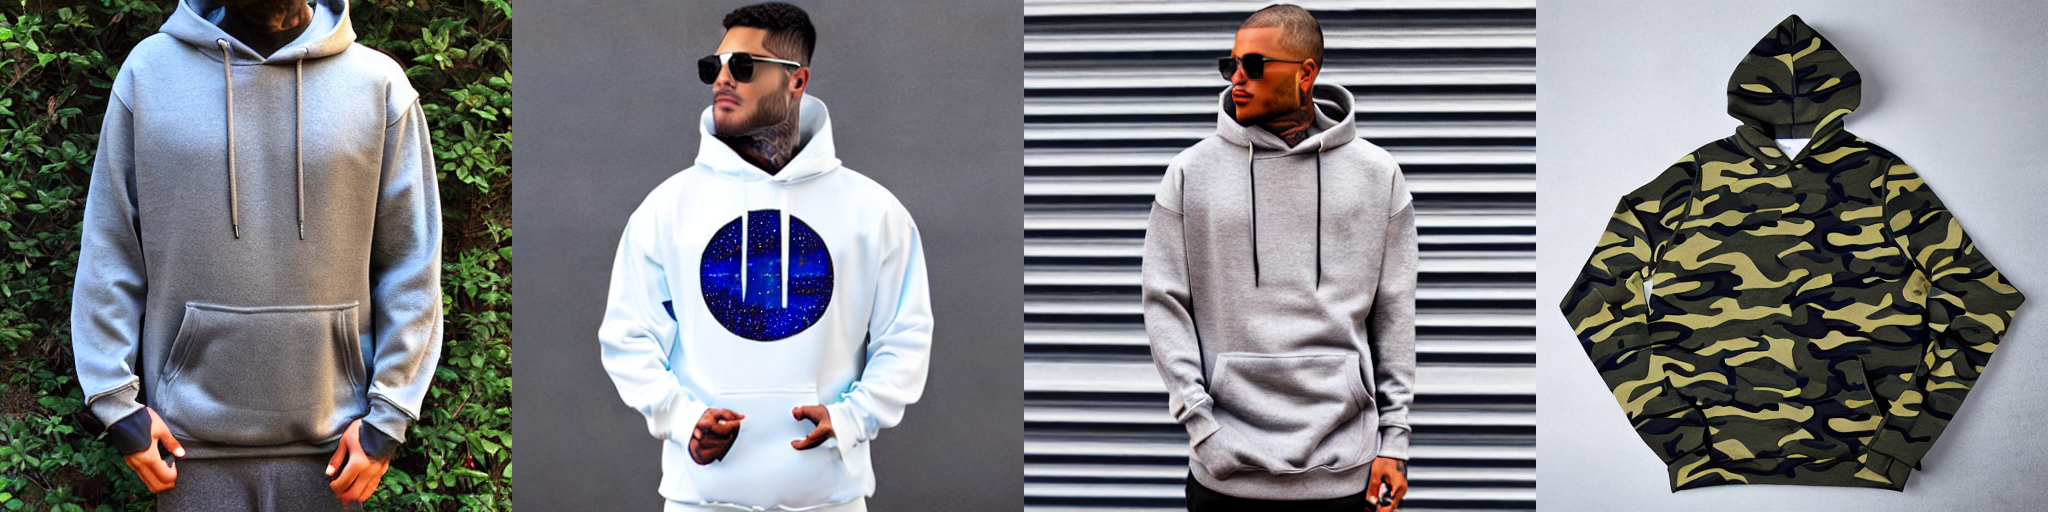

In [7]:
# Stable Diffusion V1
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

model_path = "./sd_martin_valen-model-v1-2_400_demo"
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to("cuda")

# Run inference using ChatGPT prompts to acquire 4 image panels
image1 = pipe(prompt="black hoodie with a front half zipper by martin valen").images[0]
image1.save("ProductSnapAI_panel_1.png")

image2 = pipe(prompt="white hoodie with a blue design by martin valen").images[0]
image2.save("ProductSnapAI_panel_2.png")

image3 = pipe(prompt="stripped hoodie by martin valen").images[0]
image3.save("ProductSnapAI_panel_3.png")

image4 = pipe(prompt="camouflage hoodie by martin valen").images[0]
image4.save("ProductSnapAI_panel_4.png")

# Image grid helper function from HuggingFace
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

all_images = [image1, image2, image3, image4]
grid = image_grid(all_images, rows=1, cols=4)
grid